In [55]:
import h5py
import numpy as np
from tqdm import tqdm
import cv2

def mvsecRectifyFrames(frames, x_map, y_map):
    """
    Rectifies the spatial coordinates of input frames using mapping matrices (vectorized).
    CAUTION: Ensure frames and maps correspond to the same side (e.g., DAVIS/left or DAVIS/right)!

    :param frames: np.array of shape [N, H, W] containing frames (e.g., depth maps)
    :param x_map: np.array of shape [H, W] containing rectified x-coordinates
    :param y_map: np.array of shape [H, W] containing rectified y-coordinates
    :return: rectified frames, np.array of shape [N, H, W] with invalid pixels marked as NaN
    """
    print("\nRectifying frame coordinates (vectorized)...")
    N, H, W = frames.shape
    rectified_frames = np.full((N, H, W), np.nan, dtype=np.float32)  # Initialize with NaN
    
    # Validate map dimensions
    if x_map.shape != (H, W) or y_map.shape != (H, W):
        raise ValueError(f"Expected x_map and y_map of shape ({H}, {W}), got {x_map.shape} and {y_map.shape}")
    
    # Generate pixel coordinates
    u, v = np.meshgrid(np.arange(W), np.arange(H))
    u = u.ravel()  # Shape: [H*W]
    v = v.ravel()  # Shape: [H*W]
    
    # Get rectified coordinates for all pixels (load maps once)
    u_rect = x_map[v, u]  # Shape: [H*W]
    v_rect = y_map[v, u]  # Shape: [H*W]
    
    # Filter valid mappings (non-NaN)
    valid = (~np.isnan(u_rect) & ~np.isnan(v_rect))
    u_valid = u[valid]
    v_valid = v[valid]
    u_rect_valid = u_rect[valid]
    v_rect_valid = v_rect[valid]
    
    # Round rectified coordinates
    u_rect_int = np.round(u_rect_valid).astype(int)
    v_rect_int = np.round(v_rect_valid).astype(int)
    
    # Ensure rounded coordinates are within bounds
    valid_bounds = (0 <= u_rect_int) & (u_rect_int < W) & (0 <= v_rect_int) & (v_rect_int < H)
    if not np.all(valid_bounds):
        print(f"Warning: {np.sum(~valid_bounds)} out-of-bounds rectified coordinates detected")
        u_valid = u_valid[valid_bounds]
        v_valid = v_valid[valid_bounds]
        u_rect_int = u_rect_int[valid_bounds]
        v_rect_int = v_rect_int[valid_bounds]
    
    # Process each frame
    for i in tqdm(range(N), desc="Rectifying frames"):
        frame = frames[i]
        
        # Get values for valid pixels
        values = frame[v_valid, u_valid]
        valid_values = ~np.isnan(values)
        u_rect_int_valid = u_rect_int[valid_values]
        v_rect_int_valid = v_rect_int[valid_values]
        values_valid = values[valid_values]
        
        # Handle occlusions: keep smallest depth (closest)
        # Create a unique index for each rectified pixel
        indices = v_rect_int_valid * W + u_rect_int_valid
        sort_idx = np.argsort(values_valid)  # Sort by depth (ascending)
        indices_sorted = indices[sort_idx]
        values_sorted = values_valid[sort_idx]
        u_rect_sorted = u_rect_int_valid[sort_idx]
        v_rect_sorted = v_rect_int_valid[sort_idx]
        
        # Keep the first occurrence (smallest depth) for each unique index
        _, unique_idx = np.unique(indices_sorted, return_index=True)
        unique_u_rect = u_rect_sorted[unique_idx]
        unique_v_rect = v_rect_sorted[unique_idx]
        unique_values = values_sorted[unique_idx]
        
        # Assign values to rectified frame
        rectified_frames[i, unique_v_rect, unique_u_rect] = unique_values
    
    return rectified_frames

def post_process_frames(rectified_frames, inpaint_radius=10, max_iterations=3, use_interpolation=False):
    """
    Post-process rectified frames to fill NaN regions using inpainting or interpolation.
    
    :param rectified_frames: np.array of shape [N, H, W] with NaN for invalid pixels
    :param inpaint_radius: radius for inpainting neighborhood (larger for bigger holes)
    :param max_iterations: number of inpainting iterations for large holes
    :param use_interpolation: if True, use bilinear interpolation instead of inpainting
    :return: processed frames with NaN regions filled
    """
    processed_frames = rectified_frames.copy()
    N, H, W = rectified_frames.shape
    
    if use_interpolation:
        # Bilinear interpolation to fill NaN regions
        for i in tqdm(range(N)):
            frame = rectified_frames[i]
            mask = np.isnan(frame)
            if np.any(mask):
                # Create a grid of valid coordinates
                x, y = np.meshgrid(np.arange(W), np.arange(H))
                valid = ~mask
                points = np.stack([y[valid], x[valid]], axis=-1)
                values = frame[valid]
                from scipy.interpolate import griddata
                # Interpolate NaN regions
                interpolated = griddata(points, values, (y, x), method='linear', fill_value=0)
                processed_frames[i] = np.where(mask, interpolated, frame)
    else:
        # Iterative inpainting with OpenCV (Telea method)
        for i in tqdm(range(N)):
            frame = rectified_frames[i]
            for _ in range(max_iterations):
                mask = np.isnan(frame).astype(np.uint8)
                if not np.any(mask):
                    break
                frame_inp = np.where(np.isnan(frame), 0, frame)
                frame = cv2.inpaint(frame_inp, mask, inpaintRadius=inpaint_radius, flags=cv2.INPAINT_TELEA)
            processed_frames[i] = frame
    
    return processed_frames

# Example usage
# rectified_frames = mvsecRectifyFrames(frames, x_map, y_map)
# rectified_frames_filled = post_process_frames(rectified_frames)

def mvsecLoadRectificationMaps(Lx_path, Ly_path, Rx_path, Ry_path):
    """
    Loads the rectification maps for further calibration of DAVIS' spike events coordinates.

    :param Lx_path: path of the .txt file containing the mapping of the x coordinate for the left DAVIS camera
    :param Ly_path:                     ..                              y        ..          left
    :param Rx_path:                     ..                              x        ..          right
    :param Ry_path:                     ..                              y        ..          right
    :return: all corresponding mapping matrices in the form of a numpy array
    """
    print("\nloading rectification maps...")
    Lx_map = np.loadtxt(Lx_path)
    Ly_map = np.loadtxt(Ly_path)
    Rx_map = np.loadtxt(Rx_path)
    Ry_map = np.loadtxt(Ry_path)
    return Lx_map, Ly_map, Rx_map, Ry_map


def mvsecRectifyEvents(events, x_map, y_map):
    """
    Rectifies the spatial coordinates of the input spike events in accordance to the given mapping matrices.
    CAUTION: make sure events and maps correspond to the same side (DAVIS/left or DAVIS/right) !

    :param events: a list of spike events to the format [X, Y, TIME, POLARITY]
    :param x_map: np.array obtained by mvsecLoadRectificationMaps() function
    :param y_map:                       ..
    :return: rectified events, in the same format as the input events
    """
    print("\nrectifying spike coordinates...")
    rect_events = []
    for event in tqdm(events):
        x = int(event[0])
        y = int(event[1])
        x_rect = x_map[y, x]
        y_rect = y_map[y, x]
        rect_events.append([x_rect, y_rect, event[2], event[3]])

    # convert to np.array and remove spikes falling outside of the Lidar field of view (fov)
    rect_events = np.array(rect_events)
    rect_events = rect_events[(rect_events[:, 0] >= 0)
                              & (rect_events[:, 0] <= 346)
                              & (rect_events[:, 1] >= 0)
                              & (rect_events[:, 1] <= 260)]
    return rect_events

In [117]:

root_dir = '/mnt/sdc/lxy/datasets/MVSEC/OpenDataLab___MVSEC/raw/MVSEC/hdf5/'
# scenario = 'outdoor_night'
# scenario = 'indoor_flying'
scenario = 'outdoor_day'
split = '1'
data_path = root_dir + f'{scenario}/{scenario}{split}_data.hdf5'
gt_path = root_dir + f'{scenario}/{scenario}{split}_gt.hdf5'

with h5py.File(data_path, 'r') as data, h5py.File(gt_path, 'r') as gt:
    data = data['davis']['left']
    gt = gt['davis']['left']

    print(f"Data keys: {list(data.keys())}")
    print(f"GT keys: {list(gt.keys())}")
    image_raw = data['image_raw'][:]
    image_raw_ts = data['image_raw_ts'][:]
    image_raw_event_inds = data['image_raw_event_inds'][:]
    blended_image_rect = gt['blended_image_rect'][:]
    blended_image_rect_ts = gt['blended_image_rect_ts'][:]
    depth_image_rect = gt['depth_image_rect'][:]
    depth_image_rect_ts = gt['depth_image_rect_ts'][:]
    # pose_ts = gt['pose_ts'][:]
    # pose = gt['pose'][:]
    pose_ts = gt['odometry_ts'][:]
    pose = gt['odometry'][:]
    flow_dist = gt['flow_dist'][:]
    flow_dist_ts = gt['flow_dist_ts'][:]
    # Levents = data['events'][:]
    # # remove events occurring during take-off and landing of the drone as well
    # Levents = Levents[(Levents[:, 2] > depth_image_rect_ts[0] - 0.05) & (Levents[:, 2] < depth_image_rect_ts[-1])]
    # rectify the spatial coordinates of spike events and get rid of events falling outside of the 346x260 fov
    Lx_path = root_dir + '{}/{}_calib/{}_left_x_map.txt'.format(scenario, scenario, scenario)
    Ly_path = root_dir + '{}/{}_calib/{}_left_y_map.txt'.format(scenario, scenario, scenario)
    Rx_path = root_dir + '{}/{}_calib/{}_right_x_map.txt'.format(scenario, scenario, scenario)
    Ry_path = root_dir + '{}/{}_calib/{}_right_y_map.txt'.format(scenario, scenario, scenario)
    Lx_map, Ly_map, Rx_map, Ry_map = mvsecLoadRectificationMaps(Lx_path, Ly_path, Rx_path, Ry_path)
    # rect_Levents = np.array(mvsecRectifyEvents(Levents, Lx_map, Ly_map))        
    print(f"Image raw: {image_raw.shape}")
    print(f"Image raw timestamps: {image_raw_ts.shape}")
    print(f"Image raw event indices: {image_raw_event_inds.shape}")
    print(f"Depth image rect: {depth_image_rect.shape}")
    print(f"Depth image rect timestamps: {depth_image_rect_ts.shape}")
    print(f"Flow distance: {flow_dist.shape}")
    print(f"Flow distance timestamps: {flow_dist_ts.shape}")
    print(f"Blended image rect: {blended_image_rect.shape}")
    print(f"Blended image rect timestamps: {blended_image_rect_ts.shape}")
    print(f"Pose timestamps: {pose_ts.shape}")
    print(f"Pose: {pose.shape}")



Data keys: ['events', 'image_raw', 'image_raw_event_inds', 'image_raw_ts', 'imu', 'imu_ts']
GT keys: ['blended_image_rect', 'blended_image_rect_ts', 'depth_image_raw', 'depth_image_raw_ts', 'depth_image_rect', 'depth_image_rect_ts', 'flow_dist', 'flow_dist_ts', 'odometry', 'odometry_ts', 'pose', 'pose_ts']

loading rectification maps...
Image raw: (11937, 260, 346)
Image raw timestamps: (11937,)
Image raw event indices: (11937,)
Depth image rect: (5134, 260, 346)
Depth image rect timestamps: (5134,)
Flow distance: (5134, 2, 260, 346)
Flow distance timestamps: (5134,)
Blended image rect: (5134, 260, 346, 3)
Blended image rect timestamps: (5134,)
Pose timestamps: (5137,)
Pose: (5137, 4, 4)


In [119]:
for i in range(10):
    print(flow_dist_ts[i+1], depth_image_rect_ts[i])

1506117902.3404183 1506117902.340418
1506117902.3904831 1506117902.390483
1506117902.4405167 1506117902.440516
1506117902.4906068 1506117902.490606
1506117902.5406024 1506117902.540602
1506117902.5905693 1506117902.590569
1506117902.640648 1506117902.640647
1506117902.6906347 1506117902.690634
1506117902.7406614 1506117902.740661
1506117902.79071 1506117902.790709


## Pose插值

In [120]:
from scipy.spatial.transform import Rotation, Slerp
import numpy as np
def pose_interpolate(poses, poses_timestamps, depth_timestamp):
    closest_idx = np.searchsorted(poses_timestamps, depth_timestamp)
            
    # Handle edge cases
    if closest_idx == 0:
        # If depth_timestamp is before the first pose timestamp
        interpolated_pose = poses[0]
    elif closest_idx == len(poses_timestamps):
        # If depth_timestamp is after the last pose timestamp
        interpolated_pose = poses[-1]
    else:
        # Get the two surrounding poses for interpolation
        prev_idx = closest_idx - 1
        next_idx = closest_idx
        
        # Get timestamps and poses
        t_prev = poses_timestamps[prev_idx]
        t_next = poses_timestamps[next_idx]
        pose_prev = poses[prev_idx]
        pose_next = poses[next_idx]
        
        # Calculate interpolation factor (0 to 1)
        alpha = (depth_timestamp - t_prev) / (t_next - t_prev)
        print('t_prev: ', t_prev, ' t_next: ', t_next, ' depth_timestamp: ', depth_timestamp, ' alpha: ', alpha)
        
        # Interpolate rotation using SLERP
        rot_prev = Rotation.from_matrix(pose_prev[:3, :3])  # matrix
        # rot_prev = Rotation.from_rotvec(pose_prev[0]) # rotvec
        rot_next = Rotation.from_matrix(pose_next[:3, :3])  # matrix
        # rot_next = Rotation.from_rotvec(pose_next[0]) # rotvec
        key_rots = Rotation.concatenate([rot_prev, rot_next])
        key_times = [0, 1]
        slerp = Slerp(key_times, key_rots)
        interpolated_rot = slerp([alpha])[0].as_matrix()
        
        # Linearly interpolate translation
        # interpolated_trans = (1 - alpha) * np.array(pose_prev[1]) + alpha * np.array(pose_next[1])    # translation vec
        interpolated_trans = (1 - alpha) * np.array(pose_prev[:3, 3]) + alpha * np.array(pose_next[:3, 3])
        
        # Combine into final pose
        # interpolated_pose = (interpolated_rot, interpolated_trans.tolist()) 
        # Create a 4x4 transformation matrix
        interpolated_pose = np.eye(4)  # Start with an identity matrix
        interpolated_pose[:3, :3] = interpolated_rot  # Set the rotation part
        interpolated_pose[:3, 3] = interpolated_trans  # Set the translation part

    # print("prev_pose: ", poses[prev_idx])
    # print("next_pose: ", poses[next_idx])
    # print(interpolated_pose)
    return interpolated_pose

### mask掉超过 pose_ts 范围的部分

In [121]:
max_ts = min(pose_ts.max(),image_raw_ts.max(),depth_image_rect_ts.max())
min_ts = max(pose_ts.min(),image_raw_ts.min(),depth_image_rect_ts.min())
# 1.1 去掉 image_raw_ts 中超过 pose_ts 最大值的部分
image_time_mask = (image_raw_ts >= min_ts) & (image_raw_ts <= max_ts)
filtered_image_ts = image_raw_ts[image_time_mask]
filtered_image = image_raw[image_time_mask]
image_raw_event_inds = image_raw_event_inds[image_time_mask]

# 1.2 去掉 depth_image_rect_ts 中超过 pose_ts 最大值的部分

depth_time_mask = (depth_image_rect_ts >= min_ts) & (depth_image_rect_ts <= max_ts)
filtered_depth_ts = depth_image_rect_ts[depth_time_mask]
filtered_depth = depth_image_rect[depth_time_mask]
filtered_blended_image_rect_ts = blended_image_rect_ts[depth_time_mask]
filtered_blended_image_rect = blended_image_rect[depth_time_mask]
print(min_ts,max_ts)
print(pose_ts.max(), filtered_depth_ts.max(),np.where(depth_image_rect_ts==filtered_depth_ts.max())[0][0],len(filtered_depth_ts))
print(pose_ts.max(), filtered_image_ts.max(),np.where(image_raw_ts==filtered_image_ts.max())[0][0],len(filtered_image_ts))

1506117902.340418 1506118159.0775115
1506118159.1838117 1506118159.033805 5132 5133
1506118159.1838117 1506118159.0775115 11936 11701


In [122]:
# check if any duplicate indices
def check_duplicates(values):
    unique_values, indices, counts = np.unique(values, return_index=True, return_counts=True)

    # print("Unique values:", unique_values)
    # print("Indices:", indices)
    # print("Counts:", counts)
    if counts.max() == 1:
        print("No duplicates found.")
    else:
        print(f"Duplicates found: {counts[counts > 1]} times.")
        print("Duplicate indices:", indices[counts > 1])
        print(f"Unique values: {len(unique_values)} vs Total values: {len(values)}")

In [123]:
check_duplicates(filtered_image_ts)
print(filtered_image_ts[0],filtered_image_ts[1],filtered_image_ts[2],filtered_image_ts[3])
print(len(filtered_image_ts))

No duplicates found.
1506117902.3551705 1506117902.3770695 1506117902.3989685 1506117902.4208674
11701


### 遍历 filtered_depth_ts,找到 filtered_image_ts 中最接近的值的索引 closest_indices

In [124]:
# 初始化结果数组
closest_indices = []
time_differences = []

# 遍历 filtered_depth_ts
for ts in filtered_depth_ts:
    # 找到 filtered_image_ts 中最接近的值的索引
    closest_idx = np.argmin(np.abs(filtered_image_ts - ts))
    closest_indices.append(closest_idx)
    
    # 计算差值
    time_diff = ts - filtered_image_ts[closest_idx]
    time_differences.append(time_diff)


# 转换为 NumPy 数组
closest_indices = np.array(closest_indices)
time_differences = np.array(time_differences)

# 检查是否有重复值
has_duplicates = len(closest_indices) != len(np.unique(closest_indices))

if has_duplicates:
    print("Warning: There are duplicate indices in closest_indices.")
# 打印结果
print("Closest indices:", len(closest_indices))
print("Time differences max:", time_differences.max())
print("Time differences min:", time_differences.min())
print("Time differences mean:", time_differences.mean())

# 统计差值大于 0.001 的部分
large_differences = time_differences[time_differences > 0.01]

# 打印统计结果
print("Number of differences > 0.05:", len(large_differences))
print("Largest difference > 0.005:", large_differences.max() if len(large_differences) > 0 else "None")
print("Smallest difference > 0.005:", large_differences.min() if len(large_differences) > 0 else "None")
print("Mean of differences > 0.005:", large_differences.mean() if len(large_differences) > 0 else "None")

Closest indices: 5133
Time differences max: 0.010973453521728516
Time differences min: -0.014752388000488281
Time differences mean: -4.289212014134948e-05
Number of differences > 0.05: 215
Largest difference > 0.005: 0.010973453521728516
Smallest difference > 0.005: 0.010000467300415039
Mean of differences > 0.005: 0.010475983730582304


In [125]:
check_duplicates(closest_indices)
check_duplicates(filtered_image_ts)
print(filtered_image_ts[0],filtered_image_ts[1],filtered_image_ts[2],filtered_image_ts[3])



No duplicates found.
No duplicates found.
1506117902.3551705 1506117902.3770695 1506117902.3989685 1506117902.4208674


### interpolate depth time pose and image time pose

In [126]:
from tqdm import tqdm
# 2 使用插值生成 pose_interpolated
pose_interpolated_tdepth = []
pose_interpolated_timg = []
for i,depth_timestamp in enumerate(tqdm(filtered_depth_ts)):
    pose_interpolated_tdepth.append(pose_interpolate(pose,pose_ts,depth_timestamp))
    pose_interpolated_timg.append(pose_interpolate(pose,pose_ts,filtered_image_ts[closest_indices[i]]))

  7%|▋         | 334/5133 [00:00<00:02, 1674.95it/s]

t_prev:  1506117902.290381  t_next:  1506117902.3404183  depth_timestamp:  1506117902.340418  alpha:  0.9999952351909736
t_prev:  1506117902.3404183  t_next:  1506117902.3904831  depth_timestamp:  1506117902.3551705  alpha:  0.29466109806797564
t_prev:  1506117902.3404183  t_next:  1506117902.3904831  depth_timestamp:  1506117902.390483  alpha:  0.9999952378004353
t_prev:  1506117902.3904831  t_next:  1506117902.4405167  depth_timestamp:  1506117902.3989685  alpha:  0.16959248246416592
t_prev:  1506117902.3904831  t_next:  1506117902.4405167  depth_timestamp:  1506117902.440516  alpha:  0.9999857044830741
t_prev:  1506117902.4405167  t_next:  1506117902.4906068  depth_timestamp:  1506117902.4427664  alpha:  0.04491344309424874
t_prev:  1506117902.4405167  t_next:  1506117902.4906068  depth_timestamp:  1506117902.490606  alpha:  0.9999857206094444
t_prev:  1506117902.4405167  t_next:  1506117902.4906068  depth_timestamp:  1506117902.4865654  alpha:  0.9193166835639455
t_prev:  150611790

 13%|█▎        | 677/5133 [00:00<00:02, 1609.93it/s]

t_prev:  1506117920.2484841  t_next:  1506117920.2985904  depth_timestamp:  1506117920.2906034  alpha:  0.8405983983707729
t_prev:  1506117920.2985904  t_next:  1506117920.3486526  depth_timestamp:  1506117920.348652  alpha:  0.9999857126528746
t_prev:  1506117920.3486526  t_next:  1506117920.3986917  depth_timestamp:  1506117920.3563015  alpha:  0.15285950476226778
t_prev:  1506117920.3486526  t_next:  1506117920.3986917  depth_timestamp:  1506117920.398691  alpha:  0.9999857060496763
t_prev:  1506117920.3986917  t_next:  1506117920.4488096  depth_timestamp:  1506117920.4000995  alpha:  0.028090956662385234
t_prev:  1506117920.3986917  t_next:  1506117920.4488096  depth_timestamp:  1506117920.448809  alpha:  0.9999857285571572
t_prev:  1506117920.3986917  t_next:  1506117920.4488096  depth_timestamp:  1506117920.4438975  alpha:  0.9019884877027734
t_prev:  1506117920.4488096  t_next:  1506117920.4988732  depth_timestamp:  1506117920.498873  alpha:  0.9999952376870398
t_prev:  15061179

 19%|█▉        | 994/5133 [00:00<00:02, 1443.20it/s]

t_prev:  1506117938.3691983  t_next:  1506117938.4192088  depth_timestamp:  1506117938.419208  alpha:  0.9999856978723202
t_prev:  1506117938.4192088  t_next:  1506117938.4692383  depth_timestamp:  1506117938.4231305  alpha:  0.07838866940845124
t_prev:  1506117938.4192088  t_next:  1506117938.4692383  depth_timestamp:  1506117938.469238  alpha:  0.9999952344416434
t_prev:  1506117938.4192088  t_next:  1506117938.4692383  depth_timestamp:  1506117938.4669285  alpha:  0.9538312706408246
t_prev:  1506117938.4692383  t_next:  1506117938.51914  depth_timestamp:  1506117938.519139  alpha:  0.9999808889504689
t_prev:  1506117938.4692383  t_next:  1506117938.51914  depth_timestamp:  1506117938.5107274  alpha:  0.8314166543241138
t_prev:  1506117938.51914  t_next:  1506117938.5691876  depth_timestamp:  1506117938.569187  alpha:  0.9999857085010599
t_prev:  1506117938.5691876  t_next:  1506117938.619255  depth_timestamp:  1506117938.5764244  alpha:  0.14453947180449336
t_prev:  1506117938.56918

 25%|██▌       | 1288/5133 [00:00<00:02, 1455.33it/s]

t_prev:  1506117952.8715682  t_next:  1506117952.921576  depth_timestamp:  1506117952.8765934  alpha:  0.10048725136830863
t_prev:  1506117952.8715682  t_next:  1506117952.921576  depth_timestamp:  1506117952.921575  alpha:  0.999980929496348
t_prev:  1506117952.8715682  t_next:  1506117952.921576  depth_timestamp:  1506117952.9203916  alpha:  0.9763144344642142
t_prev:  1506117952.921576  t_next:  1506117952.9715705  depth_timestamp:  1506117952.97157  alpha:  0.9999904622017054
t_prev:  1506117952.921576  t_next:  1506117952.9715705  depth_timestamp:  1506117952.9641895  alpha:  0.8523644201972417
t_prev:  1506117952.9715705  t_next:  1506117953.0216162  depth_timestamp:  1506117953.021616  alpha:  0.9999952359854603
t_prev:  1506117953.0216162  t_next:  1506117953.071578  depth_timestamp:  1506117953.0298874  alpha:  0.16555081004986757
t_prev:  1506117953.0216162  t_next:  1506117953.071578  depth_timestamp:  1506117953.071577  alpha:  0.9999809119324282
t_prev:  1506117953.071578 

 31%|███       | 1586/5133 [00:01<00:02, 1439.99it/s]

t_prev:  1506117971.8147488  t_next:  1506117971.864721  depth_timestamp:  1506117971.8631885  alpha:  0.9693319147515017
t_prev:  1506117971.864721  t_next:  1506117971.9147382  depth_timestamp:  1506117971.914738  alpha:  0.9999952332604022
t_prev:  1506117971.864721  t_next:  1506117971.9147382  depth_timestamp:  1506117971.9069865  alpha:  0.8450189954572972
t_prev:  1506117971.9147382  t_next:  1506117971.9647577  depth_timestamp:  1506117971.964757  alpha:  0.9999857004628283
t_prev:  1506117971.9647577  t_next:  1506117972.014747  depth_timestamp:  1506117971.9726844  alpha:  0.15856822626031383
t_prev:  1506117971.9647577  t_next:  1506117972.014747  depth_timestamp:  1506117972.014746  alpha:  0.9999809224018696
t_prev:  1506117972.014747  t_next:  1506117972.0647001  depth_timestamp:  1506117972.0164824  alpha:  0.03474147929304741
t_prev:  1506117972.014747  t_next:  1506117972.0647001  depth_timestamp:  1506117972.0647  alpha:  0.999995227163169
t_prev:  1506117972.014747  

 37%|███▋      | 1874/5133 [00:01<00:02, 1171.43it/s]

t_prev:  1506117986.4570234  t_next:  1506117986.5068772  depth_timestamp:  1506117986.506877  alpha:  0.9999952176449771
t_prev:  1506117986.4570234  t_next:  1506117986.5068772  depth_timestamp:  1506117986.4988616  alpha:  0.8392172241298506
t_prev:  1506117986.5068772  t_next:  1506117986.556829  depth_timestamp:  1506117986.556828  alpha:  0.9999809081059409
t_prev:  1506117986.556829  t_next:  1506117986.6067343  depth_timestamp:  1506117986.5647395  alpha:  0.1585100182497444
t_prev:  1506117986.556829  t_next:  1506117986.6067343  depth_timestamp:  1506117986.606734  alpha:  0.9999952225799978
t_prev:  1506117986.6067343  t_next:  1506117986.6566262  depth_timestamp:  1506117986.6086586  alpha:  0.0385688753811012
t_prev:  1506117986.6067343  t_next:  1506117986.6566262  depth_timestamp:  1506117986.656626  alpha:  0.9999952213015263
t_prev:  1506117986.6067343  t_next:  1506117986.6566262  depth_timestamp:  1506117986.6525764  alpha:  0.9188290277260085
t_prev:  1506117986.656

 42%|████▏     | 2168/5133 [00:01<00:02, 1306.71it/s]

t_prev:  1506117999.310302  t_next:  1506117999.3601584  depth_timestamp:  1506117999.360158  alpha:  0.999990435793088
t_prev:  1506117999.3601584  t_next:  1506117999.4100974  depth_timestamp:  1506117999.3670495  alpha:  0.1379888188141832
t_prev:  1506117999.3601584  t_next:  1506117999.4100974  depth_timestamp:  1506117999.410097  alpha:  0.9999904515919583
t_prev:  1506117999.4100974  t_next:  1506117999.4600017  depth_timestamp:  1506117999.4109674  alpha:  0.017433138729373094
t_prev:  1506117999.4100974  t_next:  1506117999.4600017  depth_timestamp:  1506117999.460001  alpha:  0.9999856674661035
t_prev:  1506117999.4100974  t_next:  1506117999.4600017  depth_timestamp:  1506117999.4548864  alpha:  0.8974984950839409
t_prev:  1506117999.4600017  t_next:  1506117999.5099695  depth_timestamp:  1506117999.509969  alpha:  0.9999904571046856
t_prev:  1506117999.5099695  t_next:  1506117999.5598805  depth_timestamp:  1506117999.5207644  alpha:  0.21628244690506443
t_prev:  1506117999

 48%|████▊     | 2453/5133 [00:01<00:01, 1361.88it/s]

t_prev:  1506118014.163665  t_next:  1506118014.2136362  depth_timestamp:  1506118014.213636  alpha:  0.9999952288710555
t_prev:  1506118014.163665  t_next:  1506118014.2136362  depth_timestamp:  1506118014.2115805  alpha:  0.9588633262402549
t_prev:  1506118014.2136362  t_next:  1506118014.263708  depth_timestamp:  1506118014.263708  alpha:  1.0
t_prev:  1506118014.2136362  t_next:  1506118014.263708  depth_timestamp:  1506118014.2554994  alpha:  0.8360608903088798
t_prev:  1506118014.263708  t_next:  1506118014.3136344  depth_timestamp:  1506118014.313634  alpha:  0.9999904491752862
t_prev:  1506118014.3136344  t_next:  1506118014.3636754  depth_timestamp:  1506118014.3213766  alpha:  0.15471658559129436
t_prev:  1506118014.3136344  t_next:  1506118014.3636754  depth_timestamp:  1506118014.363675  alpha:  0.9999952355315003
t_prev:  1506118014.3636754  t_next:  1506118014.413654  depth_timestamp:  1506118014.3652954  alpha:  0.032414872200967434
t_prev:  1506118014.3636754  t_next:  

 59%|█████▉    | 3046/5133 [00:02<00:01, 1444.21it/s]

t_prev:  1506118032.6274312  t_next:  1506118032.677484  depth_timestamp:  1506118032.677483  alpha:  0.9999809466649519
t_prev:  1506118032.677484  t_next:  1506118032.7273924  depth_timestamp:  1506118032.6794064  alpha:  0.03851794526372109
t_prev:  1506118032.677484  t_next:  1506118032.7273924  depth_timestamp:  1506118032.727392  alpha:  0.9999904457533763
t_prev:  1506118032.677484  t_next:  1506118032.7273924  depth_timestamp:  1506118032.7233245  alpha:  0.9184927220526343
t_prev:  1506118032.7273924  t_next:  1506118032.7773626  depth_timestamp:  1506118032.777362  alpha:  0.999990457559998
t_prev:  1506118032.7273924  t_next:  1506118032.7773626  depth_timestamp:  1506118032.7672434  alpha:  0.797495109499499
t_prev:  1506118032.7773626  t_next:  1506118032.8273215  depth_timestamp:  1506118032.827321  alpha:  0.9999904554196514
t_prev:  1506118032.8273215  t_next:  1506118032.8773048  depth_timestamp:  1506118032.8331215  alpha:  0.11603901834052803
t_prev:  1506118032.8273

 68%|██████▊   | 3494/5133 [00:02<00:01, 1474.13it/s]

t_prev:  1506118054.6329176  t_next:  1506118054.682953  depth_timestamp:  1506118054.682952  alpha:  0.9999809399465366
t_prev:  1506118054.6329176  t_next:  1506118054.682953  depth_timestamp:  1506118054.6826904  alpha:  0.9947537202841854
t_prev:  1506118054.682953  t_next:  1506118054.7328665  depth_timestamp:  1506118054.732866  alpha:  0.9999904467573906
t_prev:  1506118054.682953  t_next:  1506118054.7328665  depth_timestamp:  1506118054.7266085  alpha:  0.8746232439945929
t_prev:  1506118054.7328665  t_next:  1506118054.7828963  depth_timestamp:  1506118054.782896  alpha:  0.9999952344643538
t_prev:  1506118054.7828963  t_next:  1506118054.8328204  depth_timestamp:  1506118054.7924864  alpha:  0.19209444261379102
t_prev:  1506118054.7828963  t_next:  1506118054.8328204  depth_timestamp:  1506118054.83282  alpha:  0.9999904487647865
t_prev:  1506118054.8328204  t_next:  1506118054.8827677  depth_timestamp:  1506118054.8364055  alpha:  0.07177771201084518
t_prev:  1506118054.832

 74%|███████▍  | 3793/5133 [00:02<00:00, 1475.22it/s]

t_prev:  1506118077.04194  t_next:  1506118077.0918603  depth_timestamp:  1506118077.09186  alpha:  0.999995224017461
t_prev:  1506118077.04194  t_next:  1506118077.0918603  depth_timestamp:  1506118077.0812426  alpha:  0.787306393607825
t_prev:  1506118077.0918603  t_next:  1506118077.1418617  depth_timestamp:  1506118077.141861  alpha:  0.9999856952808731
t_prev:  1506118077.1418617  t_next:  1506118077.1918166  depth_timestamp:  1506118077.1471205  alpha:  0.10527094489466701
t_prev:  1506118077.1418617  t_next:  1506118077.1918166  depth_timestamp:  1506118077.191816  alpha:  0.9999904546452469
t_prev:  1506118077.1418617  t_next:  1506118077.1918166  depth_timestamp:  1506118077.1910384  alpha:  0.9844219810429254
t_prev:  1506118077.1918166  t_next:  1506118077.2417567  depth_timestamp:  1506118077.241756  alpha:  0.9999856777298247
t_prev:  1506118077.1918166  t_next:  1506118077.2417567  depth_timestamp:  1506118077.2349575  alpha:  0.8638524997135546
t_prev:  1506118077.241756

 83%|████████▎ | 4240/5133 [00:02<00:00, 1478.12it/s]

t_prev:  1506118097.5200334  t_next:  1506118097.5699227  depth_timestamp:  1506118097.5254114  alpha:  0.10779876798677186
t_prev:  1506118097.5200334  t_next:  1506118097.5699227  depth_timestamp:  1506118097.569922  alpha:  0.9999856631509527
t_prev:  1506118097.5200334  t_next:  1506118097.5699227  depth_timestamp:  1506118097.5693295  alpha:  0.9881099731900923
t_prev:  1506118097.5699227  t_next:  1506118097.6198452  depth_timestamp:  1506118097.619845  alpha:  0.9999952242227422
t_prev:  1506118097.5699227  t_next:  1506118097.6198452  depth_timestamp:  1506118097.6132486  alpha:  0.867863794832609
t_prev:  1506118097.6198452  t_next:  1506118097.6698728  depth_timestamp:  1506118097.669872  alpha:  0.9999857027798562
t_prev:  1506118097.6698728  t_next:  1506118097.7198136  depth_timestamp:  1506118097.6791265  alpha:  0.18529410360581858
t_prev:  1506118097.6698728  t_next:  1506118097.7198136  depth_timestamp:  1506118097.719813  alpha:  0.9999904519566328
t_prev:  1506118097

 88%|████████▊ | 4540/5133 [00:03<00:00, 1479.99it/s]

t_prev:  1506118114.358622  t_next:  1506118114.4081612  depth_timestamp:  1506118114.408161  alpha:  0.9999951872635743
t_prev:  1506118114.4081612  t_next:  1506118114.4581935  depth_timestamp:  1506118114.4121625  alpha:  0.07997579234790399
t_prev:  1506118114.4081612  t_next:  1506118114.4581935  depth_timestamp:  1506118114.458193  alpha:  0.9999904694283086
t_prev:  1506118114.4081612  t_next:  1506118114.4581935  depth_timestamp:  1506118114.4560814  alpha:  0.9577843326931966
t_prev:  1506118114.4581935  t_next:  1506118114.50824  depth_timestamp:  1506118114.508239  alpha:  0.999980944214187
t_prev:  1506118114.4581935  t_next:  1506118114.50824  depth_timestamp:  1506118114.5000005  alpha:  0.8353627745224144
t_prev:  1506118114.50824  t_next:  1506118114.5582788  depth_timestamp:  1506118114.558278  alpha:  0.9999857059815702
t_prev:  1506118114.5582788  t_next:  1506118114.6083133  depth_timestamp:  1506118114.5658784  alpha:  0.15188697226722578
t_prev:  1506118114.558278

 94%|█████████▍| 4842/5133 [00:03<00:00, 1476.71it/s]

t_prev:  1506118129.9146104  t_next:  1506118129.96462  depth_timestamp:  1506118129.9154744  alpha:  0.017277217338240624
t_prev:  1506118129.9146104  t_next:  1506118129.96462  depth_timestamp:  1506118129.96462  alpha:  1.0
t_prev:  1506118129.9146104  t_next:  1506118129.96462  depth_timestamp:  1506118129.9593935  alpha:  0.8954880909246935
t_prev:  1506118129.96462  t_next:  1506118130.0146744  depth_timestamp:  1506118130.014674  alpha:  0.9999904736047404
t_prev:  1506118130.0146744  t_next:  1506118130.0647097  depth_timestamp:  1506118130.0252714  alpha:  0.21179054907249015
t_prev:  1506118130.0146744  t_next:  1506118130.0647097  depth_timestamp:  1506118130.064709  alpha:  0.9999857049599025
t_prev:  1506118130.0647097  t_next:  1506118130.1147316  depth_timestamp:  1506118130.0691905  alpha:  0.08957756414228314
t_prev:  1506118130.0647097  t_next:  1506118130.1147316  depth_timestamp:  1506118130.114731  alpha:  0.9999904674295901
t_prev:  1506118130.0647097  t_next:  15

100%|██████████| 5133/5133 [00:03<00:00, 1436.53it/s]

t_prev:  1506118146.778085  t_next:  1506118146.828071  depth_timestamp:  1506118146.828071  alpha:  1.0
t_prev:  1506118146.778085  t_next:  1506118146.828071  depth_timestamp:  1506118146.8241854  alpha:  0.9222635065845644
t_prev:  1506118146.828071  t_next:  1506118146.878094  depth_timestamp:  1506118146.878093  alpha:  0.9999809352226527
t_prev:  1506118146.828071  t_next:  1506118146.878094  depth_timestamp:  1506118146.8681045  alpha:  0.8003012234820862
t_prev:  1506118146.878094  t_next:  1506118146.927945  depth_timestamp:  1506118146.927944  alpha:  0.9999808694820412
t_prev:  1506118146.927945  t_next:  1506118146.9779487  depth_timestamp:  1506118146.9339824  alpha:  0.12074037695905708
t_prev:  1506118146.927945  t_next:  1506118146.9779487  depth_timestamp:  1506118146.977948  alpha:  0.999985695962924
t_prev:  1506118146.927945  t_next:  1506118146.9779487  depth_timestamp:  1506118146.9779015  alpha:  0.9990559335529797
t_prev:  1506118146.9779487  t_next:  1506118147

In [127]:
check_duplicates(filtered_image_ts)
print(filtered_image_ts[0],filtered_image_ts[1],filtered_image_ts[2],filtered_image_ts[3])
print(len(filtered_image_ts))

No duplicates found.
1506117902.3551705 1506117902.3770695 1506117902.3989685 1506117902.4208674
11701


### check shape

In [128]:
print("filtered_depth_ts: ", filtered_depth_ts.shape)
print("filtered_depth: ", filtered_depth.shape)
print("filtered_blended_image_rect_ts: ", filtered_blended_image_rect_ts.shape)
print("filtered_blended_image_rect: ", filtered_blended_image_rect.shape)
assert np.sum(filtered_blended_image_rect_ts-filtered_depth_ts)==0
print("filtered_blended_image_rect_ts is equal to filtered_depth_ts")

print("closest_indices: ", closest_indices.shape)
print("filtered_image_ts: ", filtered_image_ts.shape)
print("filtered_image: ", filtered_image.shape)
print("image_raw_event_inds: ", image_raw_event_inds.shape)

print("pose_interpolated_tdepth: ", len(pose_interpolated_tdepth))
print("pose_interpolated_timg: ", len(pose_interpolated_timg))

filtered_depth_ts:  (5133,)
filtered_depth:  (5133, 260, 346)
filtered_blended_image_rect_ts:  (5133,)
filtered_blended_image_rect:  (5133, 260, 346, 3)
filtered_blended_image_rect_ts is equal to filtered_depth_ts
closest_indices:  (5133,)
filtered_image_ts:  (11701,)
filtered_image:  (11701, 260, 346)
image_raw_event_inds:  (11701,)
pose_interpolated_tdepth:  5133
pose_interpolated_timg:  5133


### check valid depth

In [129]:
closest_indices_unique, indices_inverse, counts = np.unique(closest_indices, return_inverse=True, return_counts=True)

print("closest_indices: ", closest_indices.shape)
print("closest_indices_unique: ", closest_indices_unique.shape)
print(closest_indices_unique[200])
print(np.where(closest_indices==closest_indices_unique[200])[0])

closest_indices:  (5133,)
closest_indices_unique:  (5133,)
456
[200]


depth_test shape:  (260, 346)
depth_test max:  nan
depth_test min:  nan
depth_test mean:  nan
depth_zeroindex:  (260, 346)
depth_zeromask sum:  0.0 (260, 346)
depth_zeromask:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


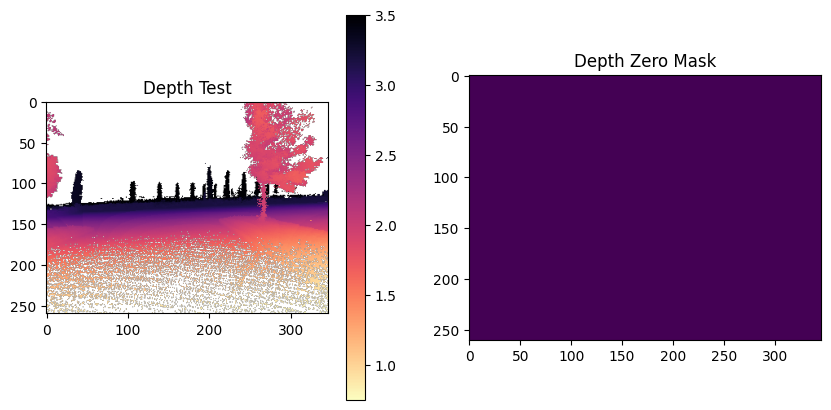

In [130]:
import matplotlib.pyplot as plt
import copy

idx = 200

depth_index=np.where(closest_indices==closest_indices_unique[idx])[0][0]
depth_test = filtered_depth[depth_index]
depth_log = np.log(depth_test+1e-6)
depth_woNan = copy.deepcopy(depth_test)

# depth_woNan[np.isnan(depth_woNan)] = 0

print("depth_test shape: ", depth_test.shape)
print("depth_test max: ", depth_woNan.max())
print("depth_test min: ", depth_woNan.min())
print("depth_test mean: ", depth_woNan.mean())

depth_zeromask = np.zeros_like(depth_test)
depth_zeroindex = (depth_test==0)
print("depth_zeroindex: ", depth_zeroindex.shape)
depth_zeromask[depth_zeroindex] = 1
print("depth_zeromask sum: ", np.sum(depth_zeromask),depth_zeromask.shape)
depth_zeromask = depth_zeromask.reshape(260,346)
print("depth_zeromask: ", depth_zeromask)

# subplot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(depth_log, cmap='magma_r',vmax=3.5)
plt.colorbar()
plt.title('Depth Test')
plt.subplot(1, 2, 2)
plt.imshow(depth_zeromask)
plt.title('Depth Zero Mask')
plt.show()


# now I have filtered_depth_ts filtered_depth filtered_image_ts pose_interpolated pose_interpolated_timg. I want to warp depth to image timestamp using pose_t@depth and pose_t@image

In [131]:

if scenario == 'outdoor_night':
    intrinsics=[225.7028124771077, 225.3928747331328, 167.3925764568589, 126.81201949043754]
elif scenario == 'outdoor_day':
    intrinsics=[223.9940010790056, 223.61783486959376, 170.7684322973841, 128.18711828338436]
elif scenario == 'indoor_flying':
    intrinsics=[226.38018519795807, 226.15002947047415, 173.6470807871759, 133.73271487507847]
fx, fy, cx, cy = intrinsics
def warp_depth_map(depth_map, T_depth, T_image):
    """Warp depth map to image timestamps."""
    H, W = depth_map.shape
    warped_depth = np.full((H, W), np.nan, dtype=np.float32)  # Initialize with NaN
        
    # Relative transformation: depth camera -> image camera
    T_depth_to_image = np.linalg.inv(T_image) @ T_depth
    
    # Convert depth map to point cloud
    u, v = np.meshgrid(np.arange(W), np.arange(H))
    valid = (depth_map > 0) & (~np.isnan(depth_map))  # Exclude NaN and non-positive depths        Z = depth_map[valid]
    Z = depth_map[valid]
    X = (u[valid] - cx) * Z / fx
    Y = (v[valid] - cy) * Z / fy
    points = np.stack([X, Y, Z, np.ones_like(Z)], axis=0)  # Shape: [4, K]
    
    # Transform points
    transformed_points = T_depth_to_image @ points  # Shape: [4, K]
    X_t, Y_t, Z_t = transformed_points[:3, :]
    
    # Project to image plane
    valid_z = Z_t > 0
    u_prime = (X_t[valid_z] * fx / Z_t[valid_z] + cx).astype(int)
    v_prime = (Y_t[valid_z] * fy / Z_t[valid_z] + cy).astype(int)
    depths = Z_t[valid_z]
    
    # Filter valid projections
    valid_proj = (0 <= u_prime) & (u_prime < W) & (0 <= v_prime) & (v_prime < H)
    u_prime, v_prime, depths = u_prime[valid_proj], v_prime[valid_proj], depths[valid_proj]
    
    # Handle occlusions (keep closest depth)
    for u_p, v_p, d in zip(u_prime, v_prime, depths):
        if np.isnan(warped_depth[v_p, u_p]) or warped_depth[v_p, u_p] > d:
                warped_depth[v_p, u_p] = d
    
    return warped_depth

In [132]:
test_warp = warp_depth_map(filtered_depth[100], pose_interpolated_tdepth[100], pose_interpolated_timg[100])
print("test_warp: ", test_warp.shape)
# 去掉nan 看max min mean
test = filtered_depth[100]
depth_zeromask = np.zeros_like(test)
depth_zeroindex = (test==0)
test[depth_zeroindex] = np.nan
test = test[~np.isnan(test)]
test_warp = test_warp[~np.isnan(test_warp)]
print("valid percentage: ", np.sum(~np.isnan(test))/260/346, np.sum(~np.isnan(test_warp)))
print("depth max: ", test.max(),test_warp.max())
print("depth min: ", test.min(),test_warp.min())
print("depth mean: ", test.mean(),test_warp.mean())
print("depth shape: ", test.shape,test_warp.shape)

test_warp:  (260, 346)
valid percentage:  0.5162850155624722 46109
depth max:  119.83418 119.8189
depth min:  2.0953207 2.0753465
depth mean:  11.367535 11.391152
depth shape:  (46445,) (46109,)


In [133]:
filtered_depth.shape,np.array(pose_interpolated_tdepth).shape,np.array(pose_interpolated_timg).shape
check_duplicates(np.array(pose_interpolated_timg)[:,0,0])

No duplicates found.


In [134]:
warped_dapth_maps = np.zeros((len(filtered_depth_ts), 260, 346))
for i in tqdm(range(len(filtered_depth_ts))):
    depth_zeromask = np.zeros_like(filtered_depth[i])
    depth_zeroindex = (filtered_depth[i]==0)
    filtered_depth[i][depth_zeroindex] = np.nan
    warped_dapth_maps[i] = warp_depth_map(filtered_depth[i], pose_interpolated_tdepth[i], pose_interpolated_timg[i])

100%|██████████| 5133/5133 [05:59<00:00, 14.30it/s]


### for night seqs, filter duplicated aps frames：夜间mvsec 一个frame可能对应多个depth，把depths都投到image上，如果一个pixel对应了多个depth,取最小的那个

In [73]:
check_duplicates(closest_indices)
print(closest_indices[:4])
check_duplicates(filtered_image_ts)
print(filtered_image_ts[0],filtered_image_ts[1],filtered_image_ts[2],filtered_image_ts[3])
print(filtered_depth_ts[0],filtered_depth_ts[1],filtered_depth_ts[2],filtered_depth_ts[3])
check_duplicates(filtered_depth_ts)

No duplicates found.
[0 1 3 4]
No duplicates found.
1504645268.0252624 1504645268.0571222 1504645268.0889814 1504645268.1208403
1504645268.012208 1504645268.0621128 1504645268.1121068 1504645268.16204
No duplicates found.


In [74]:
hight, width = filtered_image.shape[1:3]
# 初始化一个图像大小的深度图，填充为无穷大（用于取最小值）
closest_indices_unique, indices, counts = np.unique(closest_indices, return_index=True, return_counts=True)
print(closest_indices_unique.shape, indices.shape, counts.shape)
unique_depths = np.full((len(closest_indices_unique), hight, width), np.inf)
print(unique_depths.shape)
test_idx = 10
original_idx = indices[test_idx]
duplicate_count = counts[test_idx]
print("original_idx: ", original_idx)
print("duplicate_count: ", duplicate_count)
print(len(closest_indices))
print(closest_indices[original_idx-1:original_idx+duplicate_count+1])
print("pose_interpolated_timg: ", np.array(pose_interpolated_timg).shape)

(1691,) (1691,) (1691,)
(1691, 260, 346)
original_idx:  10
duplicate_count:  1
1691
[14 15 17]
pose_interpolated_timg:  (1691, 4, 4)


In [75]:
closest_indices = closest_indices[indices]
pose_interpolated_timg = np.array(pose_interpolated_timg)[indices]
print("pose_interpolated_timg: ", pose_interpolated_timg.shape)
print("closest_indices: ", closest_indices.shape)

pose_interpolated_timg:  (1691, 4, 4)
closest_indices:  (1691,)


In [76]:
for i in tqdm(range(len(counts))):
    original_idx = indices[i]
    duplicate_count = counts[i]
    if duplicate_count > 1:
        # 找到重复索引的位置
        
        # 获取对应的深度图
        depths = warped_dapth_maps[original_idx:original_idx+duplicate_count]
        # print(f"Processing duplicate index {unique_indices[i]} with {counts[i]} duplicates")
        
        min_depth_image = unique_depths[i]  # 初始化为无穷大
        
        # 遍历所有重复的深度图
        for depth in depths:
            # 对每个像素取最小深度，忽略NaN值
            min_depth_image = np.nanmin([min_depth_image, depth], axis=0)
        
        # 处理完成后，`min_depth_image` 是该索引对应的最小深度图
        # print(f"Min depth image for index {unique_indices[i]} computed")
        unique_depths[i] = min_depth_image
    elif counts[i] == 1:
        # 如果没有重复索引，直接使用原始深度图
        unique_depths[i] = warped_dapth_maps[original_idx]
        # print(f"Unique index {unique_indices[i]} with no duplicates, using original depth image")
    else:
        print(f"Error: Index {unique_indices[i]} has {counts[i]} occurrences")

# 将所有仍为np.inf的点设置为np.nan
unique_depths[np.isinf(unique_depths)] = np.nan


100%|██████████| 1691/1691 [00:00<00:00, 3365.47it/s]


check depth

depth_test shape:  (260, 346)
depth_test max:  6.838554382324219
depth_test min:  0.4321447014808655
depth_test mean:  1.4380612414584282
depth_zeroindex:  (260, 346)
depth_zeromask sum:  0.0 (260, 346)
depth_zeromask:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


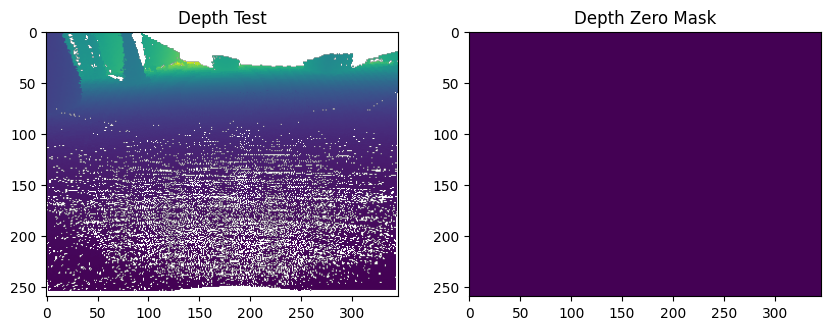

In [77]:
import matplotlib.pyplot as plt

depth_test = unique_depths[200]
depth_woNan = depth_test[~np.isnan(depth_test)]
print("depth_test shape: ", depth_test.shape)
print("depth_test max: ", depth_woNan.max())
print("depth_test min: ", depth_woNan.min())
print("depth_test mean: ", depth_woNan.mean())

depth_zeromask = np.zeros_like(depth_test)
depth_zeroindex = (depth_test==0)
print("depth_zeroindex: ", depth_zeroindex.shape)
depth_zeromask[depth_zeroindex] = 1
print("depth_zeromask sum: ", np.sum(depth_zeromask),depth_zeromask.shape)
depth_zeromask = depth_zeromask.reshape(260,346)
print("depth_zeromask: ", depth_zeromask)

# subplot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(depth_test)
plt.title('Depth Test')
plt.subplot(1, 2, 2)
plt.imshow(depth_zeromask)
plt.title('Depth Zero Mask')
plt.show()


In [78]:
# check delta t
delta_t_img = np.diff(filtered_image_ts)
print('Delta t image:', delta_t_img.max(), delta_t_img.min(), delta_t_img.mean())

Delta t image: 0.0318601131439209 0.031857967376708984 0.03185936534386774


In [80]:
print("filtered_depth: ", filtered_depth.shape)
print("filtered_depth_ts: ", filtered_depth_ts.shape)
print("filtered_blended_image_rect_ts: ", filtered_blended_image_rect_ts.shape)
print("filtered_blended_image_rect: ", filtered_blended_image_rect.shape)
print("pose_interpolated_tdepth: ", len(pose_interpolated_tdepth))

print("filtered_image_ts: ", filtered_image_ts.shape)
print("filtered_image: ", filtered_image.shape)
assert np.sum(filtered_blended_image_rect_ts-filtered_depth_ts)==0
print("unique_blended_frames_ts is equal to unique_frames_ts")
print("closest_indices: ", closest_indices.shape)
print("pose_interpolated_timg: ", len(pose_interpolated_timg))
print("unique_depths: ", unique_depths.shape)


filtered_depth:  (1691, 260, 346)
filtered_depth_ts:  (1691,)
filtered_blended_image_rect_ts:  (1691,)
filtered_blended_image_rect:  (1691, 260, 346, 3)
pose_interpolated_tdepth:  1691
filtered_image_ts:  (2653,)
filtered_image:  (2653, 260, 346)
unique_blended_frames_ts is equal to unique_frames_ts
closest_indices:  (1691,)
pose_interpolated_timg:  1691
unique_depths:  (1691, 260, 346)


In [81]:
if scenario == 'outdoor_day' or scenario == 'indoor_flying':
    filtered_image_ts = filtered_image_ts[closest_indices]
    filtered_image = filtered_image[closest_indices]

In [82]:
print("filtered_depth: ", filtered_depth.shape)
print("filtered_depth_ts: ", filtered_depth_ts.shape)
print("filtered_blended_image_rect_ts: ", filtered_blended_image_rect_ts.shape)
print("filtered_blended_image_rect: ", filtered_blended_image_rect.shape)
print("pose_interpolated_tdepth: ", len(pose_interpolated_tdepth))

print("filtered_image_ts: ", filtered_image_ts.shape)
print("filtered_image: ", filtered_image.shape)
assert np.sum(filtered_blended_image_rect_ts-filtered_depth_ts)==0
print("unique_blended_frames_ts is equal to unique_frames_ts")
print("closest_indices: ", closest_indices.shape)
print("pose_interpolated_timg: ", len(pose_interpolated_timg))
print("unique_depths: ", unique_depths.shape)


filtered_depth:  (1691, 260, 346)
filtered_depth_ts:  (1691,)
filtered_blended_image_rect_ts:  (1691,)
filtered_blended_image_rect:  (1691, 260, 346, 3)
pose_interpolated_tdepth:  1691
filtered_image_ts:  (1691,)
filtered_image:  (1691, 260, 346)
unique_blended_frames_ts is equal to unique_frames_ts
closest_indices:  (1691,)
pose_interpolated_timg:  1691
unique_depths:  (1691, 260, 346)


In [83]:
rectified_frames = mvsecRectifyFrames(filtered_image, Lx_map, Ly_map)


Rectifying frame coordinates (vectorized)...


Rectifying frames: 100%|██████████| 1691/1691 [00:17<00:00, 96.44it/s] 


In [33]:
rectified_frames_filled = post_process_frames(rectified_frames, inpaint_radius=3, max_iterations=1)
# rectified_frames_filled = post_process_frames(rectified_frames, inpaint_radius=10, max_iterations=3)

KeyboardInterrupt: 

In [84]:
rectified_frames_interpolated = post_process_frames(rectified_frames[:2835], use_interpolation=True)


100%|██████████| 1691/1691 [32:13<00:00,  1.14s/it]


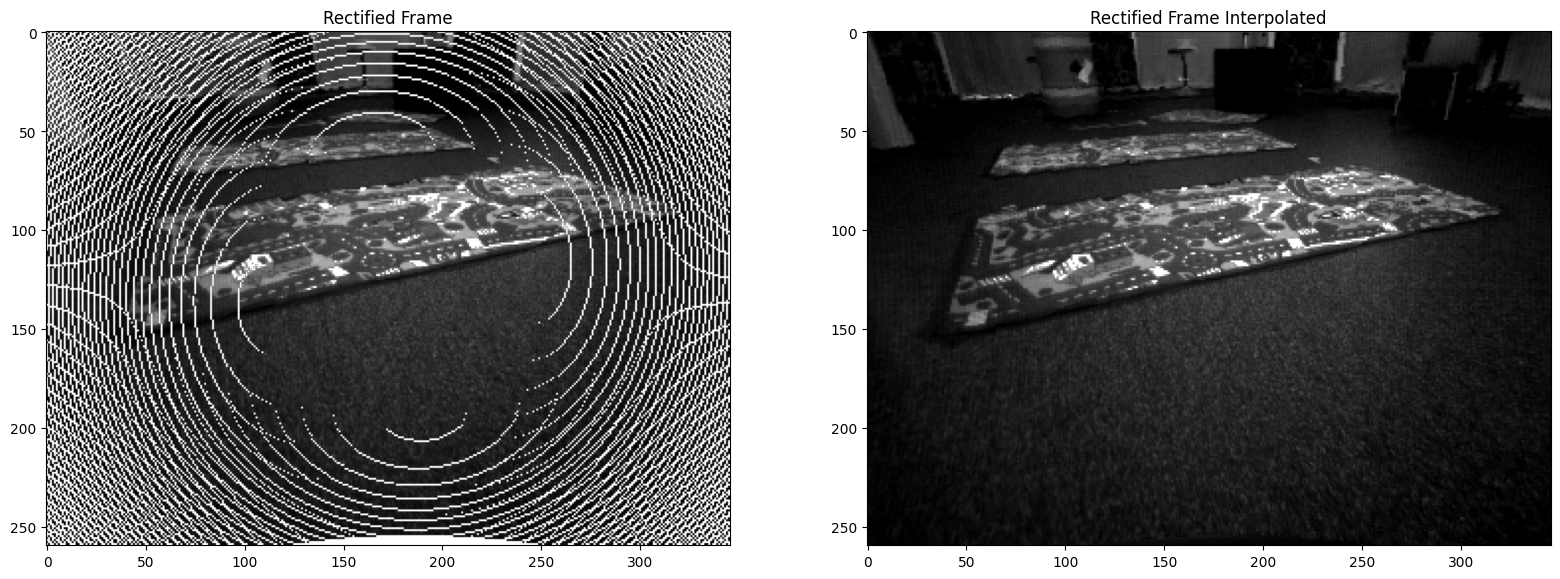

In [85]:
# visualize rectified_frames_interpolated[0],which is an rgb image
show_id= 800
plt.figure(figsize=(30, 15))
plt.subplot(1, 3, 1)
plt.imshow(rectified_frames[show_id], cmap='gray')
plt.title('Rectified Frame')
plt.subplot(1, 3, 2)
plt.imshow(rectified_frames_interpolated[show_id], cmap='gray')
plt.title('Rectified Frame Interpolated')
# plt.subplot(1, 3, 3)
# plt.imshow(rectified_frames_filled[show_id], cmap='gray')
# plt.title('Rectified Frame Inpainted')
plt.show()

### from cam2world 4x4 matrix to TUM format (timestamp tx ty tz qx qy qz qw)

In [86]:
import numpy as np
from scipy.spatial.transform import Rotation

def pose_to_tum_format(pose_matrix, timestamp):
    """
    Convert a 4x4 cam2world pose matrix and a timestamp into TUM format.
    
    Args:
        pose_matrix (numpy.ndarray): 4x4 cam2world pose matrix.
        timestamp (float): Timestamp associated with the pose.
    
    Returns:
        list: TUM format [timestamp, tx, ty, tz, qx, qy, qz, qw].
    """
    # Extract translation (tx, ty, tz)
    translation = pose_matrix[:3, 3]
    
    # Extract rotation matrix
    rotation_matrix = pose_matrix[:3, :3]
    
    # Convert rotation matrix to quaternion (qx, qy, qz, qw)
    rotation = Rotation.from_matrix(rotation_matrix)
    quaternion = rotation.as_quat()  # Returns (qx, qy, qz, qw) in scalar-last format
    
    # Combine timestamp, translation, and quaternion
    tum_format = [timestamp] + translation.tolist() + quaternion.tolist()
    return tum_format

# # Example usage
# pose_matrix = np.array([
#     [9.999870054014201592e-01, -6.783491248622387868e-04, -5.052610292199584754e-03, -6.177237162906222719e-03],
#     [6.795571388277872778e-04, 9.999997409277674443e-01, 2.373741621417125940e-04, 8.765831434655172935e-03],
#     [5.052447960653402154e-03, -2.408046149535413298e-04, 9.999872073095446012e-01, 6.781479467645386283e-02],
#     [0.000000000000000000e+00, 0.000000000000000000e+00, 0.000000000000000000e+00, 1.000000000000000000e+00]
# ])
# timestamp = 1234567890.123456

# tum_pose = pose_to_tum_format(pose_matrix, timestamp)
# print("TUM Format:", tum_pose)

In [87]:
import cv2
import os
save_root = '/mnt/sdc/lxy/datasets/MVSEC/processed_rect_odem/' + f'{scenario}/{scenario}{split}/'
depth_root = save_root + 'depth_left/'
depth_filted_root = save_root + 'depth_filtered_left/'
depth_template = '_left_depth.npy'
blended_image_template = '_left_blended_image.png'
blended_image_root = save_root + 'blended_image_left/'
image_root = save_root + 'image_left/'
image_template = '_left.png'
pose_timg_root = save_root + 'odem_pose_left.txt'
c2wpose_timg_root = save_root + 'odem_c2wpose_left.txt'
pose_tdepth_root = save_root + 'odem_pose_tdepth_left.txt'
c2wpose_tdepth_root = save_root + 'odem_c2wpose_tdepth_left.txt'
pose_origin_root = save_root + 'odem_pose_origin_left.txt'
c2wpose_origin_root = save_root + 'odem_c2wpose_origin_left.txt'
image_timestamp_root = save_root + 'index_It_left.txt'
depth_timestamp_root = save_root + 'index_Dt_left.txt'

In [88]:
save_root

'/mnt/sdc/lxy/datasets/MVSEC/processed_rect_odem/indoor_flying/indoor_flying2/'

In [90]:
# Ensure directories exist
os.makedirs(depth_root, exist_ok=True)
os.makedirs(depth_filted_root, exist_ok=True)
os.makedirs(image_root, exist_ok=True)
os.makedirs(image_root.replace('image_left','image_left_inpainted'), exist_ok=True)
os.makedirs(image_root.replace('image_left','image_left_interpolated'), exist_ok=True)
os.makedirs(blended_image_root, exist_ok=True)

for j in tqdm(range(len(unique_depths))):
    # Save depth
    depth_filename = depth_root + f'{j:06d}' + depth_template
    np.save(depth_filename, unique_depths[j])

    # Save image
    image_filename = image_root + f'{j:06d}' + image_template
    # cv2.imwrite(image_filename.replace('image_left','image_left_inpainted'), rectified_frames_filled[j].astype(np.uint8))
    cv2.imwrite(image_filename.replace('image_left','image_left_interpolated'), rectified_frames_interpolated[j].astype(np.uint8))
    
    
    # Save index
    index_filename = image_timestamp_root
    with open(index_filename, 'a') as f:
         # Write index, filtered_image_ts, and filtered_depth_ts to the combined file
        f.write(f"{np.where(image_raw_ts==filtered_image_ts[j])[0][0]}\t{filtered_image_ts[j]:.18e}\n")
    
    # Save pose
    pose_timg_filename = pose_timg_root
    with open(pose_timg_filename, 'a') as f:
        f.write(" ".join(map(str, pose_to_tum_format(pose_interpolated_timg[j], filtered_image_ts[j]))) + "\n")

    # save c2wpose
    c2wpose_timg_filename = c2wpose_timg_root
    with open(c2wpose_timg_filename, 'a') as f:
        pose_flattened = pose_interpolated_timg[j].flatten()
        pose_flattened_str = " ".join(f"{value:.18e}" for value in pose_flattened)
        f.write(f"{pose_flattened_str}\n")

for j in tqdm(range(len(filtered_depth))):
    # Save depth
    depth_filename = depth_filted_root + f'{j:06d}' + depth_template
    np.save(depth_filename, filtered_depth[j])

    # Save blended image
    blended_image_filename = blended_image_root + f'{j:06d}' + blended_image_template
    cv2.imwrite(blended_image_filename, filtered_blended_image_rect[j])

    # Save index
    index_filename = depth_timestamp_root
    with open(index_filename, 'a') as f:
         # Write index and filtered_depth_ts to the combined file
        f.write(f"{np.where(depth_image_rect_ts==filtered_depth_ts[j])[0][0]}\t{filtered_depth_ts[j]:.18e}\n")

    pose_tdepth_filename = pose_tdepth_root
    with open(pose_tdepth_filename, 'a') as f:
        f.write(" ".join(map(str, pose_to_tum_format(pose_interpolated_tdepth[j], filtered_depth_ts[j]))) + "\n")

    # save c2wpose
    c2wpose_tdepth_filename = c2wpose_tdepth_root
    with open(c2wpose_tdepth_filename, 'a') as f:
        pose_flattened = pose_interpolated_tdepth[j].flatten()
        pose_flattened_str = " ".join(f"{value:.18e}" for value in pose_flattened)
        f.write(f"{pose_flattened_str}\n")
for j in tqdm(range(len(pose))):
    # Save original pose
    pose_origin_filename = pose_origin_root
    with open(pose_origin_filename, 'a') as f:
        f.write(" ".join(map(str, pose_to_tum_format(pose[j], pose_ts[j]))) + "\n")
    # save c2wpose
    c2wpose_origin_filename = c2wpose_origin_root
    with open(c2wpose_origin_filename, 'a') as f:
        pose_flattened = pose[j].flatten()
        pose_flattened_str = " ".join(f"{value:.18e}" for value in pose_flattened)
        f.write(f"{pose_flattened_str}\n")
    


100%|██████████| 1693/1693 [00:00<00:00, 6688.48it/s]


## Visuzalization Overlay

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from matplotlib.colors import Normalize
import h5py
import copy

def read_voxel_hdf5(file_path):
    with h5py.File(file_path, 'r') as f:
        voxel_data = f['event_voxels'][:]
    # B, H, W = voxel_data.shape
    # voxel_data = voxel_data.reshape(3, 2, H, W).sum(axis=1)  # New shape: (B//2, H, W)
    return voxel_data

def render_event_voxels(event_stream):
    T, H, W = event_stream.shape
    # print(f"Rendering event stream with shape: {event_stream.shape}")
    img_outs = []
    img_0_inds = []
    img_pos_inds = []
    img_neg_inds = []
    for t in range(T):
        img_acc = event_stream[t]
        img_out = np.full((H,W,3), fill_value=255,dtype='uint8')

        # # Simple thresholding
        # img_out[img_acc > 0] = [0,0,255]
        # img_out[img_acc < 0] = [255,0,0]
        # img_outs.append(img_out)

        # With weighting (more complicated alternative)
        clip_percentile = 80
        min_percentile = -np.percentile(np.abs(img_acc[img_acc < 0]), clip_percentile)
        max_percentile = np.percentile(np.abs(img_acc[img_acc > 0]), clip_percentile)
        img_acc = np.clip(img_acc, min_percentile, max_percentile)


        img_acc_max = img_acc.max()
        idx_pos = img_acc > 0
        img_acc[idx_pos] = img_acc[idx_pos]/img_acc_max
        val_pos = img_acc[idx_pos]
        img_out[idx_pos] = np.stack((255-val_pos*255, 255-val_pos*255, np.ones_like(val_pos)*255), axis=1)

        img_acc_min = img_acc.min()
        idx_neg = img_acc < 0
        img_acc[idx_neg] = img_acc[idx_neg]/img_acc_min
        val_neg = img_acc[idx_neg]
        img_out[idx_neg] = np.stack((np.ones_like(val_neg)*255, 255-val_neg*255, 255-val_neg*255), axis=1)
        img_outs.append(img_out)

        idx_zero = img_acc == 0

        img_0_inds.append(idx_zero)
        img_pos_inds.append(idx_pos)
        img_neg_inds.append(idx_neg)
    return np.array(img_outs), np.array(img_0_inds), np.array(img_pos_inds), np.array(img_neg_inds)

In [52]:
plt.hist(gray_frame.ravel(), 256, [0, 256])

NameError: name 'gray_frame' is not defined

/tmp/ipykernel_1732054/2978199122.py:44: RuntimeWarning: invalid value encountered in cast
  depth_map_nonan_rgb = cv2.cvtColor(depth_map_nonan.astype(np.uint8), cv2.COLOR_GRAY2RGB)
/tmp/ipykernel_1732054/2978199122.py:87: RuntimeWarning: invalid value encountered in divide
  overlay = 0.5 * gray_frame/255.0 + 0.5 * depth_map_nonan/depth_map_nonan.max()  # 混合 RGB 和 depth 图像
/tmp/ipykernel_1732054/2978199122.py:88: RuntimeWarning: invalid value encountered in divide
  overlay_event = 0.5 * rendered_events[0]/rendered_events[0].max() + 0.9 * depth_map_nonan_rgb/depth_map_nonan_rgb.max()  # 混合 RGB 和 depth 图像
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4].


1 0
(5, 260, 346) float32 -7.296387 4.8365126 2.221989e-09


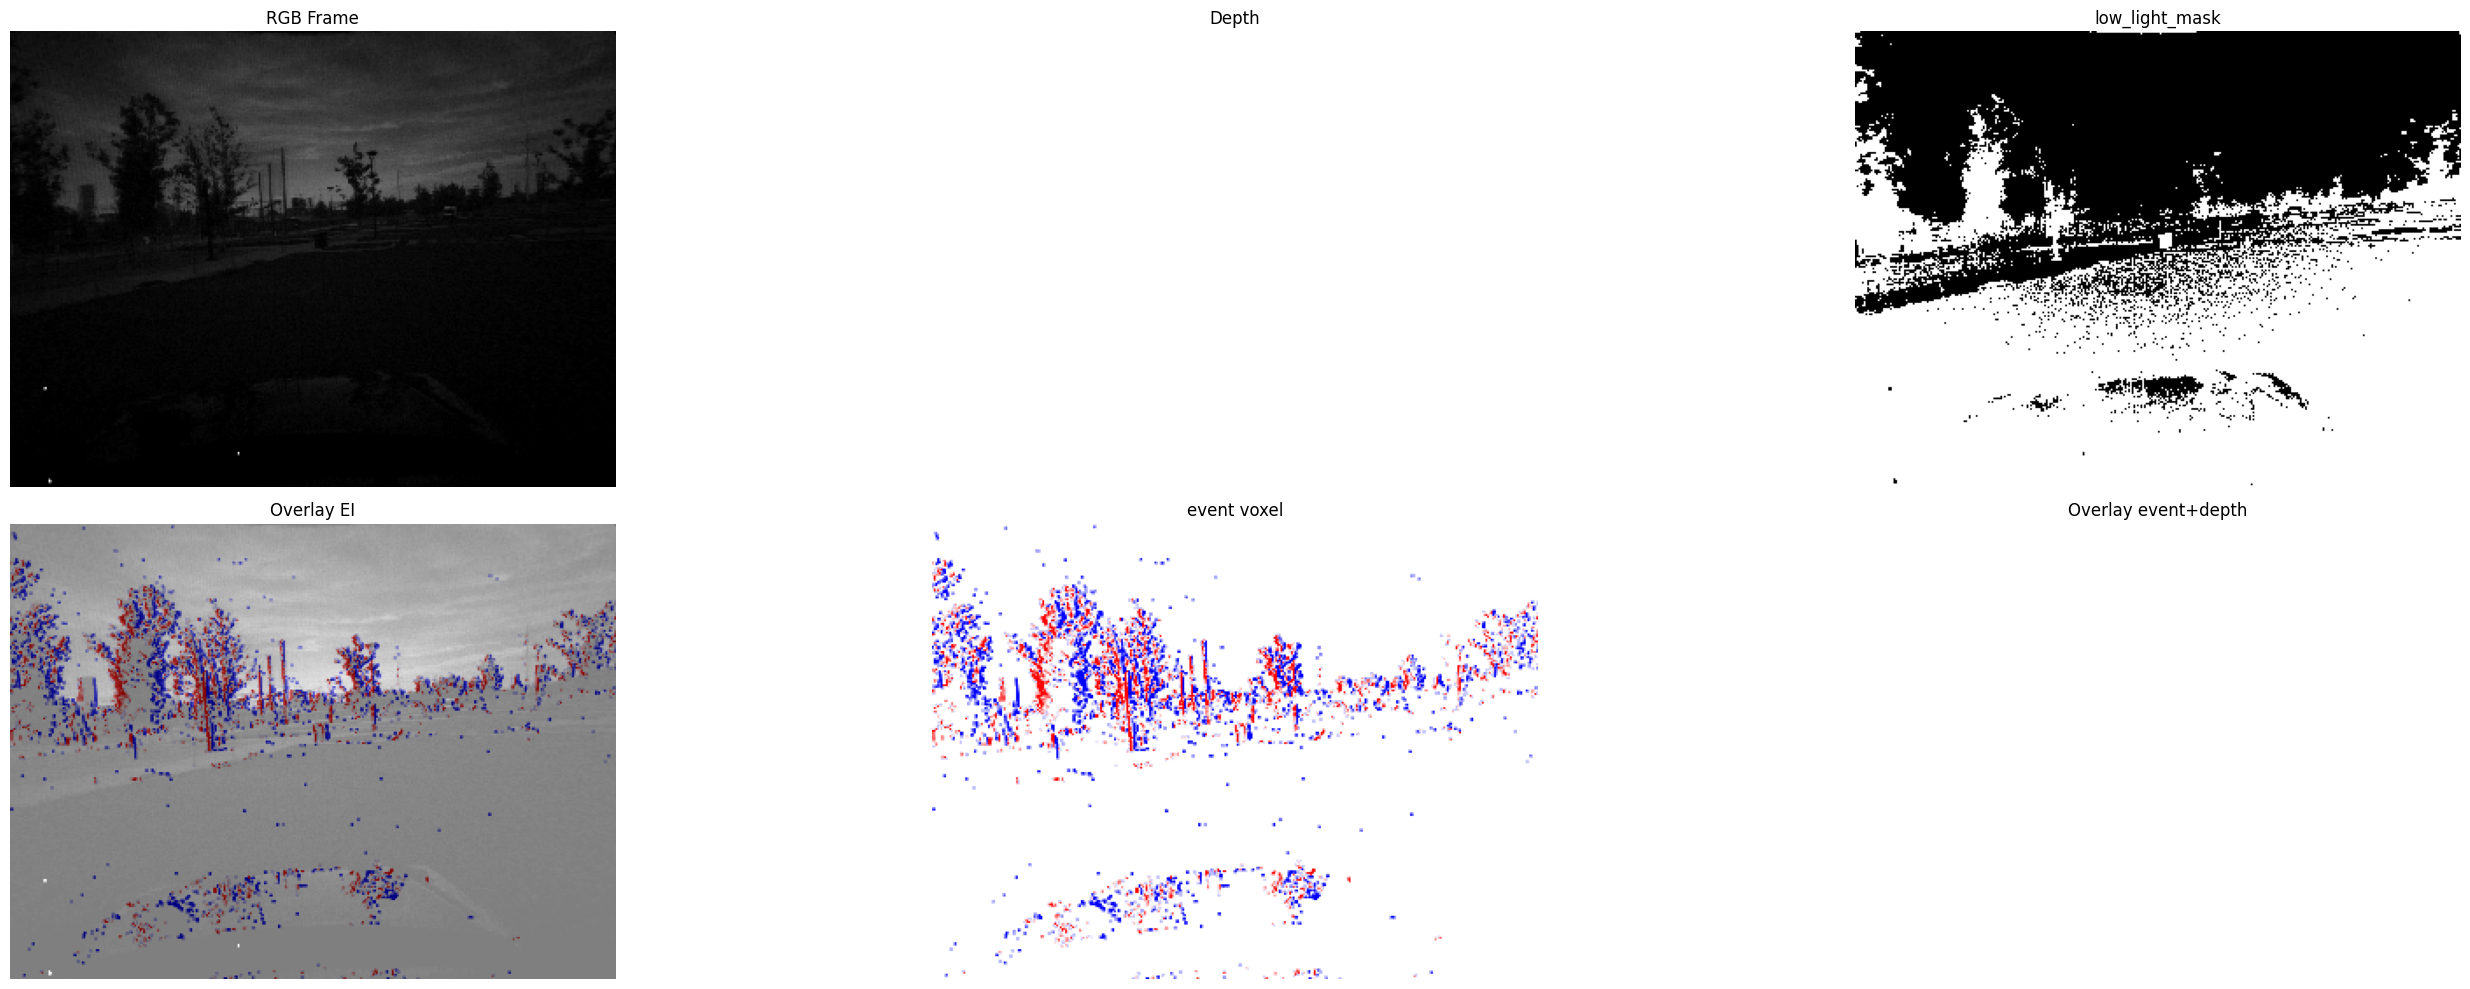

In [116]:
import cv2
import os
import numpy as np
import copy

# scenario = 'indoor_flying'
# scenario = 'outdoor_night'
scenario = 'outdoor_day'
split = '1'
save_root = '/mnt/sdc/lxy/datasets/MVSEC/processed_rect_odem/' + f'{scenario}/{scenario}{split}/'
depth_root = save_root + 'depth_left/'
depth_filted_root = save_root + 'depth_filtered_left/'
depth_template = '_left_depth.npy'
blended_image_template = '_left_blended_image.png'
blended_image_root = save_root + 'blended_image_left/'
image_root = save_root + 'image_left_interpolated/'
image_template = '_left.png'
pose_timg_root = save_root + 'odem_pose_left.txt'
pose_tdepth_root = save_root + 'odem_pose_tdepth_left.txt'
pose_origin_root = save_root + 'odem_pose_origin_left.txt'
image_timestamp_root = save_root + 'index_It_left.txt'
depth_timestamp_root = save_root + 'index_Dt_left.txt'

event_root = save_root + 'event_left/event_voxel_left/'
event_template = '_event.hdf5'
os.makedirs(event_root, exist_ok=True)

idx = 1396
depth_path = depth_root + f'{idx:06d}' + depth_template
depth_filted_path = depth_filted_root + f'{idx:06d}' + depth_template
image_path = image_root + f'{idx:06d}' + image_template
event_path = event_root + f'{idx:06d}_{idx+1:06d}' + event_template
blended_image_path = blended_image_root + f'{idx:06d}' + blended_image_template
timestamp_path = image_timestamp_root
pose_path = pose_timg_root

# visualize depth map and image map and their overlay
depth_map = np.load(depth_path).astype(np.float32)
# depth to 3 channel 
depth_map_rgb = np.stack((depth_map,)*3, axis=-1)
# if nan set to zero
depth_map_nonan = copy.deepcopy(depth_map)
depth_map_nonan[np.isnan(depth_map)] = 0
depth_map_nonan_rgb = cv2.cvtColor(depth_map_nonan.astype(np.uint8), cv2.COLOR_GRAY2RGB)
# 显示depth error map
gray_frame = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
rgb_frame = cv2.cvtColor(gray_frame,cv2.COLOR_GRAY2RGB)

# ############# low light mask #####################
# # Step 3: Define threshold for low-light areas
LL_threshold = 10  # Adjust this value (0-255) based on your image
# HL_threshold = 220  # Adjust this value (0-255) based on your image
# # Alternatively, use Otsu's method for automatic thresholding
# # _, threshold = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# # Step 4: Create binary mask (low-light areas = 255, others = 0)
# _, low_light_mask = cv2.threshold(gray_frame, LL_threshold, 255, cv2.THRESH_BINARY_INV)
# _, high_light_mask = cv2.threshold(gray_frame, HL_threshold, 255, cv2.THRESH_BINARY)
# # THRESH_BINARY_INV ensures pixels <= threshold are 255 (white)

# # Step 5: Optional - Apply morphological operations to reduce noise
# kernel = np.ones((5, 5), np.uint8)
# low_light_mask = cv2.morphologyEx(low_light_mask, cv2.MORPH_OPEN, kernel)  # Remove small noise
# low_light_mask = cv2.morphologyEx(low_light_mask, cv2.MORPH_CLOSE, kernel)  # Close small gaps
# high_light_mask = cv2.morphologyEx(high_light_mask, cv2.MORPH_OPEN, kernel)  # Remove small noise
# high_light_mask = cv2.morphologyEx(high_light_mask, cv2.MORPH_CLOSE, kernel)  # Close small gaps
# ##################################################

############# HSV mask #####################
hsv_image = cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2HSV)
value_channel = hsv_image[:, :, 2]  # 使用Value通道
_, low_light_mask = cv2.threshold(value_channel, LL_threshold, 1, cv2.THRESH_BINARY_INV)
#############################################
print(low_light_mask.max(),low_light_mask.min())

# ############ adaptive thresholding #####################
# low_light_mask = cv2.adaptiveThreshold(gray_frame, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                              cv2.THRESH_BINARY, 11, 2)
# #######################################################
# Normalize depth map for visualization

event_voxel = read_voxel_hdf5(event_path)
print(event_voxel.shape, event_voxel.dtype, event_voxel.min(), event_voxel.max(), event_voxel.mean())
rendered_events, img_0_inds, img_pos_inds, img_neg_inds = render_event_voxels(event_voxel) 

# 创建叠加图像
overlay = 0.5 * gray_frame/255.0 + 0.5 * depth_map_nonan/depth_map_nonan.max()  # 混合 RGB 和 depth 图像
overlay_event = 0.5 * rendered_events[0]/rendered_events[0].max() + 0.9 * depth_map_nonan_rgb/depth_map_nonan_rgb.max()  # 混合 RGB 和 depth 图像
overlay_EI = 0.5 * rendered_events[0]/rendered_events[0].max() + 0.9 * rgb_frame/255.0  # 混合 RGB 和 depth 图像
# 创建 1 行 3 列的子图
fig, axes = plt.subplots(2, 3, figsize=(30, 10))

# 显示 RGB 图像
axes[0,0].imshow(gray_frame, cmap='gray')
axes[0,0].set_title("RGB Frame")
axes[0,0].axis('off')

# 显示 Depth 图像
axes[0,1].imshow(np.log(depth_map+1e-6), cmap='magma_r')
axes[0,1].set_title("Depth")
axes[0,1].axis('off')

# 显示low light mask
axes[0,2].imshow(low_light_mask, cmap='gray')
axes[0,2].set_title("low_light_mask")
axes[0,2].axis('off')
# low_light_mask colorbar


# 显示 EI图像
axes[1,0].imshow(overlay_EI)
axes[1,0].set_title("Overlay EI")
axes[1,0].axis('off')

# 显示 Depth 图像
axes[1,1].imshow(rendered_events[0])
axes[1,1].set_title("event voxel")
axes[1,1].axis('off')

# 显示叠加图像
axes[1,2].imshow(overlay_event)
axes[1,2].set_title("Overlay event+depth")
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

### copy dataset into small seqs

In [3]:
import cv2
import os
scenario = 'outdoor_day'
split = '2'
source_root = '/mnt/sdc/lxy/datasets/MVSEC/processed_rect_odem/' + f'{scenario}/{scenario}{split}/'
depth_root = source_root + 'depth_left/'
depth_template = '_left_depth.npy'
image_root = source_root + 'image_left_interpolated/'
image_template = '_left.png'
imgae_evlight_root = '/mnt/sdc/yifei/code/3d/evlight/visualization/lightup/'
imgae_evlight_template = '.png'
pose_timg_root = source_root + 'odem_pose_left.txt'
c2wpose_timg_root = source_root + 'odem_c2wpose_left.txt'
image_timestamp_root = source_root + 'index_It_left.txt'
event_root = source_root + 'event_left/event_voxel_left/'
event_stream_root = source_root + 'event_left/event_stream_left/'
event_template = '_event.hdf5'

In [4]:
import os
import shutil
from tqdm import tqdm

num_sample = len(os.listdir(depth_root))
seq_length = 40
num_seq = num_sample // seq_length 
last_seq_length = num_sample % seq_length
assert last_seq_length != 0
assert num_seq*seq_length + last_seq_length == num_sample

# 写入时间戳文件
with open(image_timestamp_root, 'r') as src_file:
    image_timestamps = src_file.readlines()

# 写入位姿文件
with open(pose_timg_root, 'r') as src_file:
    pose_timg = src_file.readlines()

# 写入位姿文件
with open(c2wpose_timg_root, 'r') as src_file:
    c2wpose_timg = src_file.readlines()

for ii in tqdm(range(num_seq + 1)):
    if ii == num_seq:
        n = last_seq_length
    else:
        n = seq_length
    # 定义目标路径
    target_root = f'/mnt/sdc/lxy/datasets/MVSEC/monst3r_test_rect_odem/{scenario}/{scenario}{split}/seq{ii}/'

    depth_root_target = target_root + 'depth_left/'
    os.makedirs(depth_root_target, exist_ok=True)

    image_root_target = target_root + 'image_left_interpolated/'
    os.makedirs(image_root_target, exist_ok=True)

    # image_evlight_root_target = image_root_target.replace('image_left_interpolated','image_evlight_left')
    # os.makedirs(image_evlight_root_target, exist_ok=True)

    pose_timg_root_target = target_root + 'odem_pose_left.txt'
    c2wpose_timg_root_target = target_root + 'odem_c2wpose_left.txt'
    image_timestamp_root_target = target_root + 'index_It_left.txt'

    event_root_target = target_root + 'event_left/event_voxel_left/'
    event_stream_root_target = target_root + 'event_left/event_stream_left/'
    os.makedirs(event_root_target, exist_ok=True)
    os.makedirs(event_stream_root_target, exist_ok=True)

    with open(image_timestamp_root_target, 'w') as tgt_file:
        # 写入时间戳文件
        for idx in range(0, n):
            line = image_timestamps[ii*seq_length+idx]
            tgt_file.write(line)
    
    with open(pose_timg_root_target, 'w') as tgt_file:
        # 写入位姿文件
        for idx in range(0, n):
            line = pose_timg[ii*seq_length+idx]
            tgt_file.write(line)
    
    with open(c2wpose_timg_root_target, 'w') as tgt_file:
        # 写入位姿文件
        for idx in range(0, n):
            line = c2wpose_timg[ii*seq_length+idx]
            tgt_file.write(line)

    # 建立软链接
    for idx in range(0, n):
        real_idx = ii*seq_length+idx
        # Depth
        depth_path = depth_root + f'{real_idx:06d}' + depth_template
        depth_target_path = depth_root_target + f'{real_idx:06d}' + depth_template
        if not os.path.exists(depth_target_path):
            os.symlink(depth_path, depth_target_path)

        # Image
        image_path = image_root + f'{real_idx:06d}' + image_template
        image_target_path = image_root_target + f'{real_idx:06d}' + image_template
        if not os.path.exists(image_target_path):
            os.symlink(image_path, image_target_path)

        # # evlight
        # imgae_evlight_path = imgae_evlight_root + f'{real_idx}' + imgae_evlight_template
        # if os.path.exists(imgae_evlight_path):
        #     imgae_evlight_target_path = image_evlight_root_target + f'{real_idx:06d}' + image_template
        #     # read and write the image as gray
        #     img = cv2.imread(imgae_evlight_path, cv2.IMREAD_GRAYSCALE)
        #     cv2.imwrite(imgae_evlight_target_path, img)

        # Event
        event_path = event_root + f'{real_idx:06d}_{real_idx+1:06d}' + event_template
        event_target_path = event_root_target + f'{real_idx:06d}_{real_idx+1:06d}' + event_template
        if not os.path.exists(event_target_path):
            os.symlink(event_path, event_target_path)

        # Event Stream
        event_stream_path = event_stream_root + f'{real_idx:06d}_{real_idx+1:06d}' + event_template
        event_stream_target_path = event_stream_root_target + f'{real_idx:06d}_{real_idx+1:06d}' + event_template
        if not os.path.exists(event_stream_target_path):
            os.symlink(event_stream_path, event_stream_target_path)



100%|██████████| 305/305 [00:04<00:00, 63.08it/s]


## visualization pose

In [ ]:
import numpy as np
import open3d as o3d
import os
from tqdm import tqdm

def depth_to_point_cloud(depth, c2w_pose, intrinsics):
    """
    Convert a depth map to a point cloud using camera intrinsics and camera-to-world pose.
    
    Args:
        depth: Depth map (H, W)
        c2w_pose: Camera-to-world pose (4x4 matrix)
        intrinsics: Camera intrinsics [fx, fy, cx, cy]
    
    Returns:
        points: 3D points in world coordinates (N, 3)
    """
    fx, fy, cx, cy = intrinsics
    h, w = depth.shape
    
    # Create pixel grid
    u, v = np.meshgrid(np.arange(w), np.arange(h))
    u = u.flatten()
    v = v.flatten()
    z = depth.flatten()
    
    # Filter out invalid depths (e.g., zero or negative)
    valid = z > 0
    u, v, z = u[valid], v[valid], z[valid]
    
    # Back-project to camera coordinates
    x = (u - cx) * z / fx
    y = (v - cy) * z / fy
    points_cam = np.stack([x, y, z], axis=-1)
    
    # Transform to world coordinates
    points_world = points_cam @ c2w_pose[:3, :3].T + c2w_pose[:3, 3]
    
    return points_world

def main():
    # Define paths (modify these to match your dataset)
    seq_id = 38
    seq_length = 50
    scenario = 'outdoor_day'
    # scenario = 'outdoor_night'
    split = '2'
    dataset_root = f'/home/xy/work/3d/monst3r/data/MVSEC/monst3r_test_rect_odem/{scenario}/{scenario}{split}/'
    depth_root = dataset_root + f"seq{seq_id}/depth_left"  # Directory with depth .npy files
    c2wpose_timg_root = dataset_root + f"seq{seq_id}/odem_c2wpose_left.txt"  # File with camera-to-world poses
    image_root = dataset_root + f"seq{seq_id}/image_left"  # Directory with images (optional, for colors)
    output_ply = dataset_root + f"seq{seq_id}/point_cloud_{seq_id}.ply"  # Output PLY file

    # dataset_root = f'/home/xy/work/3d/monst3r/data/MVSEC/processed_raw/{scenario}/{scenario}{split}/'
    # depth_root = dataset_root + f"depth_left"  # Directory with depth .npy files
    # c2wpose_timg_root = dataset_root + f"c2wpose_left.txt"  # File with camera-to-world poses
    # image_root = dataset_root + f"image_left"  # Directory with images (optional, for colors)
    # output_ply = dataset_root + f"point_cloud_all.ply"  # Output PLY file
    
    # Camera intrinsics (replace with your actual values)
    fx = 223.9940010790056      # focal length x
    fy = 223.61783486959376     # focal length y
    cx = 170.7684322973841      # optical center x
    cy = 128.18711828338436     # optical center y
    width = 346
    height = 260
    intrinsics = [fx, fy, cx, cy]
    
    # Read poses
    poses = []
    with open(c2wpose_timg_root, 'r') as f:
        for line in f:
            pose_flat = np.array([float(x) for x in line.strip().split()])
            pose = pose_flat.reshape(4, 4)  # Reshape to 4x4 matrix
            poses.append(pose)
    
    # Initialize point cloud
    all_points = []
    all_colors = []  # Optional: for colored point cloud
    
    # Process each depth map and pose
    for idx in tqdm(range(len(poses))):
        j = seq_id*seq_length+idx
        print(f"Processing frame {j}")
        # Load depth map
        depth_filename = os.path.join(depth_root, f"{j:06d}_left_depth.npy")
        if not os.path.exists(depth_filename):
            print(f"Depth file {depth_filename} not found, skipping.")
            continue
        depth = np.load(depth_filename)
        
        # Convert depth to point cloud
        points = depth_to_point_cloud(depth, poses[idx], intrinsics)
        all_points.append(points)
        
        # Optional: Load image for colors
        image_filename = os.path.join(image_root, f"{j:06d}_left.png")
        if os.path.exists(image_filename):
            import cv2
            image = cv2.imread(image_filename)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            colors = image.reshape(-1, 3) / 255.0  # Normalize to [0, 1]
            valid = depth.flatten() > 0
            colors = colors[valid]
            all_colors.append(colors)
    
    # Combine all points
    all_points = np.concatenate(all_points, axis=0)
    
    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(all_points)
    
    # Add colors if available
    if all_colors:
        all_colors = np.concatenate(all_colors, axis=0)
        pcd.colors = o3d.utility.Vector3dVector(all_colors)

    # Save point cloud to PLY file
    o3d.io.write_point_cloud(output_ply, pcd)
    print(f"Point cloud saved to {output_ply}")

if __name__ == "__main__":
    main()

 36%|███▌      | 18/50 [00:00<00:00, 173.02it/s]

Processing frame 1900
Processing frame 1901
Processing frame 1902
Processing frame 1903
Processing frame 1904
Processing frame 1905
Processing frame 1906
Processing frame 1907
Processing frame 1908
Processing frame 1909
Processing frame 1910
Processing frame 1911
Processing frame 1912
Processing frame 1913
Processing frame 1914
Processing frame 1915
Processing frame 1916
Processing frame 1917
Processing frame 1918
Processing frame 1919
Processing frame 1920
Processing frame 1921
Processing frame 1922
Processing frame 1923
Processing frame 1924
Processing frame 1925
Processing frame 1926
Processing frame 1927
Processing frame 1928
Processing frame 1929
Processing frame 1930
Processing frame 1931
Processing frame 1932
Processing frame 1933


100%|██████████| 50/50 [00:00<00:00, 166.77it/s]


Processing frame 1934
Processing frame 1935
Processing frame 1936
Processing frame 1937
Processing frame 1938
Processing frame 1939
Processing frame 1940
Processing frame 1941
Processing frame 1942
Processing frame 1943
Processing frame 1944
Processing frame 1945
Processing frame 1946
Processing frame 1947
Processing frame 1948
Processing frame 1949


Point cloud saved to /home/xy/work/3d/monst3r/data/MVSEC/monst3r_test_rect_odem/outdoor_day/outdoor_day2/seq38/point_cloud_38.ply


## generate video

In [26]:
import cv2
import os
scenario = 'outdoor_night'
split = '1'
save_root = '/mnt/sdc/lxy/datasets/MVSEC/processed_rect_odem/' + f'{scenario}/{scenario}{split}/'
depth_root = save_root + 'depth_left/'
depth_filted_root = save_root + 'depth_filtered_left/'
depth_template = '_left_depth.npy'
blended_image_template = '_left_blended_image.png'
blended_image_root = save_root + 'blended_image_left/'
image_root = save_root + 'image_left/'
image_template = '_left.png'
pose_timg_root = save_root + 'odem_pose_left.txt'
c2wpose_timg_root = save_root + 'odem_c2wpose_left.txt'
pose_tdepth_root = save_root + 'odem_pose_tdepth_left.txt'
c2wpose_tdepth_root = save_root + 'odem_c2wpose_tdepth_left.txt'
pose_origin_root = save_root + 'odem_pose_origin_left.txt'
c2wpose_origin_root = save_root + 'odem_c2wpose_origin_left.txt'
image_timestamp_root = save_root + 'index_It_left.txt'
depth_timestamp_root = save_root + 'index_Dt_left.txt'
event_root = save_root + 'event_left/event_voxel_left/'
event_template = '_event.hdf5'

In [20]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# 视频保存路径
output_video_path = f"{scenario}{split}_video.mp4"
frame_width, frame_height = 346*2, 260*2  # 视频帧大小
fps = 30  # 帧率
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 视频编码格式
video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

num_frame = len(os.listdir(image_root))
# 生成视频帧
for idx in tqdm(range(num_frame-1)):  # 示例帧范围
    # 加载图像
    image_path = image_root + f'{idx:06d}' + image_template
    depth_path = depth_root + f'{idx:06d}' + depth_template
    event_path = event_root + f'{idx:06d}_{idx+1:06d}' + event_template

    # 读取 image
    gray_frame = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    rgb_frame = cv2.cvtColor(gray_frame, cv2.COLOR_GRAY2RGB)

    # 读取 depth
    depth_map = np.load(depth_path).astype(np.float32)
    depth_map_nonan = np.nan_to_num(depth_map)  # 替换 NaN 为 0
    depth_map_normalized = cv2.normalize(depth_map_nonan, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    depth_map_rgb = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_JET)

    # 读取 event
    event_voxel = read_voxel_hdf5(event_path)
    rendered_events, _, _, _ = render_event_voxels(event_voxel)
    event_frame = rendered_events[0]

    # 生成 mask
    hsv_image = cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2HSV)
    value_channel = hsv_image[:, :, 2]
    LL_threshold = 10
    _, low_light_mask = cv2.threshold(value_channel, LL_threshold, 255, cv2.THRESH_BINARY_INV)
    mask_frame = cv2.cvtColor(low_light_mask, cv2.COLOR_GRAY2RGB)

    # 创建一个空白帧
    frame = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)

    # 将各部分图像放置到对应位置
    h, w = frame_height // 2, frame_width // 2
    frame[:h, :w] = cv2.resize(rgb_frame, (w, h))  # 左上角 image
    frame[:h, w:] = cv2.resize(depth_map_rgb, (w, h))  # 右上角 depth
    frame[h:, :w] = cv2.resize(event_frame, (w, h))  # 左下角 event
    frame[h:, w:] = cv2.resize(mask_frame, (w, h))  # 右下角 mask

    # 在右上角显示帧 ID
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = (255, 255, 255)
    thickness = 2
    text = f"ID: {idx}"
    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
    text_x = frame_width - text_size[0] - 10
    text_y = text_size[1] + 10
    cv2.putText(frame, text, (text_x, text_y), font, font_scale, font_color, thickness)

    # 写入视频帧
    video_writer.write(frame)

# 释放视频写入器
video_writer.release()
print(f"Video saved to {output_video_path}")

100%|██████████| 12193/12193 [04:19<00:00, 47.03it/s]

Video saved to outdoor_day2_video.mp4


## visualize pose traj

In [32]:
import numpy as np
import open3d as o3d

# 读取 pose.txt 文件
def read_poses(file_path):
    poses = []
    with open(file_path, 'r') as f:
        for line in f:
            values = [float(x) for x in line.strip().split()]
            pose_matrix = np.array(values).reshape(4, 4)
            poses.append(pose_matrix)
    return np.array(poses)

# 提取轨迹位置
def extract_trajectory(poses):
    positions = [pose[:3, 3] for pose in poses]
    return np.array(positions)

# 保存轨迹为 PLY 文件
def save_trajectory(positions, output_path="trajectory.ply"):
    # 创建点云
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(positions)

    # 添加线段（轨迹）
    lines = [[i, i + 1] for i in range(len(positions) - 1)]
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(positions),
        lines=o3d.utility.Vector2iVector(lines)
    )
    line_set.paint_uniform_color([0, 0, 1])  # 蓝色轨迹

    # 保存为 PLY 文件
    o3d.io.write_line_set(output_path, line_set)
    print(f"Trajectory saved to {output_path}")
# 主程序
if __name__ == "__main__":
    # 假设 c2wpose_tdepth_root 是文件路径变量
    try:
        # poses = read_poses(c2wpose_tdepth_root)
        poses = read_poses(c2wpose_origin_root)
        print(poses.shape)
        positions = extract_trajectory(poses)
        print(positions.shape)
        save_trajectory(positions, output_path=f"{scenario}{split}_origin_trajectory.ply")

        print(f"Total poses: {len(poses)}")
        print(f"Trajectory shape: {positions.shape}")
    except NameError:
        print("Error: 'c2wpose_tdepth_root' is not defined. Please set the file path.")
    except Exception as e:
        print(f"Error: {e}")

(5136, 4, 4)
(5136, 3)
Trajectory saved to outdoor_night1_origin_trajectory.ply
Total poses: 5136
Trajectory shape: (5136, 3)
